In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from multiproduct import generate_dataset
n_nodes, supplies, demands, costs, capacities = generate_dataset(
                nodes=20, levels=4, total_supplies=[500,400,300], 
                total_demands=[400,600,400], transp_costs=(10,100), 
                random_state=42)

In [5]:
np.random.seed(42)
n_items = len(supplies)
permutation_size = sum([n_items * sum(n_nodes[1:])])
demand_size = n_items * n_nodes[-1]
chromosome = np.concatenate([np.random.permutation(permutation_size),
                             np.random.rand(demand_size)])

In [15]:
from multiproduct import transportation_tree
X = transportation_tree(chromosome[:permutation_size], n_nodes, supplies,
                        demands, costs, capacities, 
                        chromosome[permutation_size:])

In [16]:
X[-1]

array([[[94., 19., 10., 16., 30.,  0.],
        [ 0.,  0.,  0., 12., 40., 26.],
        [ 6.,  1., 40., 12., 40., 54.]],

       [[24., 21., 19., 50.,  0., 30.],
        [ 8., 20.,  2., 33.,  1., 30.],
        [24., 21., 19., 33.,  6., 59.]],

       [[ 7., 24., 39., 16., 12.,  0.],
        [ 0., 18.,  0., 14., 14.,  3.],
        [ 4., 18., 41.,  0., 14., 76.]]])

## Genetic Algorithm

In [18]:
from multiproduct import chromosome_fitness
chromosome_fitness(chromosome, n_nodes, supplies, demands,
                   costs, capacities, variable_demands=True)

(106462.0, 13.223931809807256)

In [19]:
import random
from deap import creator, base, tools, algorithms

In [ ]:
del creator.FitnessMin
del creator.Individual

In [20]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,-1.0))
creator.create('Individual', list, fitness=creator.FitnessMin)

In [21]:
def create_chromosome(permutation_size, demand_size):
    perm = np.random.permutation(permutation_size).astype(int)
    demand = np.random.uniform(size=demand_size)
    return list(perm) + list(demand)

In [22]:
n_items = len(supplies)
permutation_size = sum([n_items * sum(n_nodes[1:])])
demand_size = n_items * n_nodes[-1]

In [23]:
toolbox = base.Toolbox()
toolbox.register('chromosome', create_chromosome, 
                permutation_size=permutation_size,
                demand_size=demand_size)
toolbox.register('individual', tools.initIterate, creator.Individual,
                toolbox.chromosome)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [24]:
from functools import partial
ga_fitness = lambda x: partial(chromosome_fitness, 
                         n_nodes=n_nodes, supplies=supplies, 
                         demands=demands, costs=costs, 
                         capacities=capacities,
                         variable_demands=True)(x)

In [25]:
def custom_crossover(ind1, ind2, permutation_size):
    perm1 = ind1[:permutation_size]
    perm2 = ind2[:permutation_size]
    demand1 = ind1[permutation_size:]
    demand2 = ind2[permutation_size:]
    perm_child1, perm_child2 = tools.cxPartialyMatched(perm1, perm2)
    demand_child1, demand_child2 = tools.cxSimulatedBinaryBounded(
                                        demand1, demand2, 20, 0, 1)
    child1 = list(perm_child1) + list(demand_child1)
    child2 = list(perm_child2) + list(demand_child2)
    for i, x in enumerate(child1):
        ind1[i] = child1[i]
        ind2[i] = child2[i]
    return ind1, ind2

In [26]:
def custom_mutation(ind, permutation_size):
    perm = ind[:permutation_size]
    demand = ind[permutation_size:]
    perm_mut = tools.mutShuffleIndexes(perm, 2.0/len(perm))
    demand_mut = tools.mutPolynomialBounded(demand, 20, 0, 1, 1.0/len(demand))
    mut = list(perm_mut[0]) + list(demand_mut[0])
    for i, x in enumerate(mut):
        ind[i] = mut[i]
    return ind,

In [31]:
toolbox.register('evaluate', ga_fitness)
toolbox.register('mate', custom_crossover, 
                         permutation_size=permutation_size)
toolbox.register('mutate', custom_mutation,
                         permutation_size=permutation_size)
toolbox.register('select', tools.selNSGA2)

In [32]:
toolbox.pop_size = 50

In [33]:
import copy
pop = toolbox.population(n=toolbox.pop_size)
hof = tools.HallOfFame(20)
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

In [34]:
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, 
                                     mu=toolbox.pop_size,
                                     lambda_=toolbox.pop_size,
                                     cxpb=0.5, mutpb=0.2, ngen=70, 
                    stats=stats, halloffame=hof, verbose=False)

In [35]:
from multiproduct import plot_fronts, get_animation

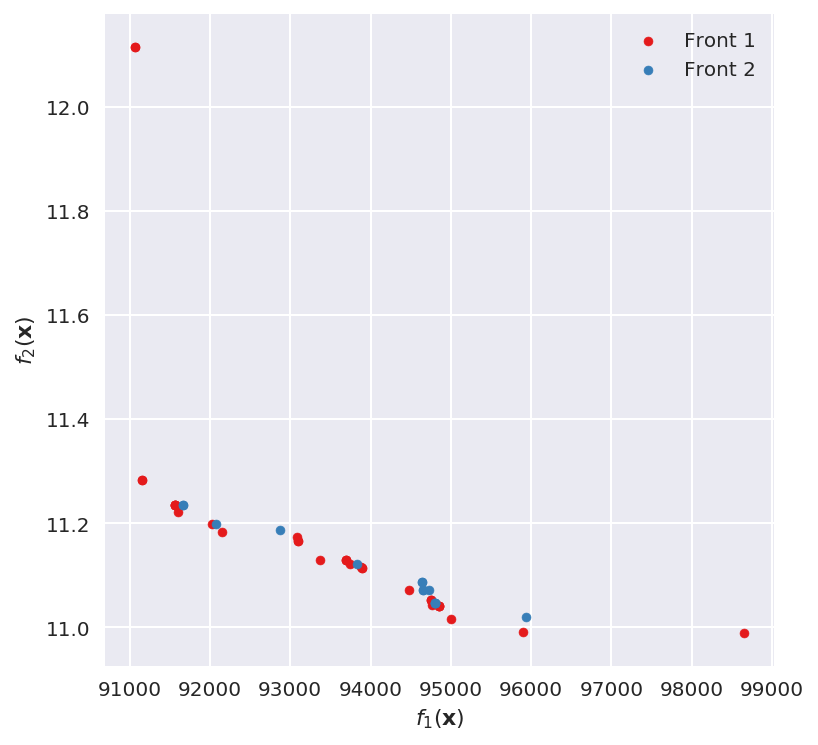

In [40]:
fronts = tools.emo.sortLogNondominated(pop, len(pop))
plot_fronts(fronts, toolbox)

In [46]:
anim = get_animation(log, toolbox)

In [47]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [48]:
sorted([item.fitness.values[0] + item.fitness.values[1] * 10000 \
        for item in pop])

[203812.85062358275,
 203921.03812358278,
 203921.03812358278,
 203921.03812358278,
 203921.03812358278,
 203921.03812358278,
 203976.22562358278,
 203994.66383219953,
 203994.66383219953,
 204009.71541950112,
 204021.03812358278,
 204021.03812358278,
 204060.71541950112,
 204669.17545351473,
 204747.67545351473,
 204760.15617913834,
 204760.15617913834,
 204819.34367913834,
 204957.69628684808,
 204986.8334750567,
 204986.8334750567,
 204986.8334750567,
 205035.3436791383,
 205035.3436791383,
 205041.22562358278,
 205049.69628684808,
 205175.87840136053,
 205190.30725623583,
 205196.71853741497,
 205254.98256802722,
 205254.98256802722,
 205254.98256802722,
 205254.98256802722,
 205264.54506802722,
 205264.54506802722,
 205264.54506802722,
 205264.54506802722,
 205277.31420068027,
 205277.31420068027,
 205277.31420068027,
 205373.04506802722,
 205373.04506802722,
 205448.71853741497,
 205519.62670068027,
 205519.62670068027,
 205810.56590136053,
 206125.98256802722,
 208543.8171768707

## Tradeoff solutions

In [52]:
from utils import plot_graph

In [65]:
best_fairness = pop[min(range(len(pop)), 
                       key=lambda i: pop[i].fitness.values[1])]
best_fairness.fitness.values

(98648.0, 10.989581717687075)

In [66]:
X = transportation_tree(best_fairness[:permutation_size], n_nodes, supplies,
                        demands, costs, capacities, 
                        best_fairness[permutation_size:])

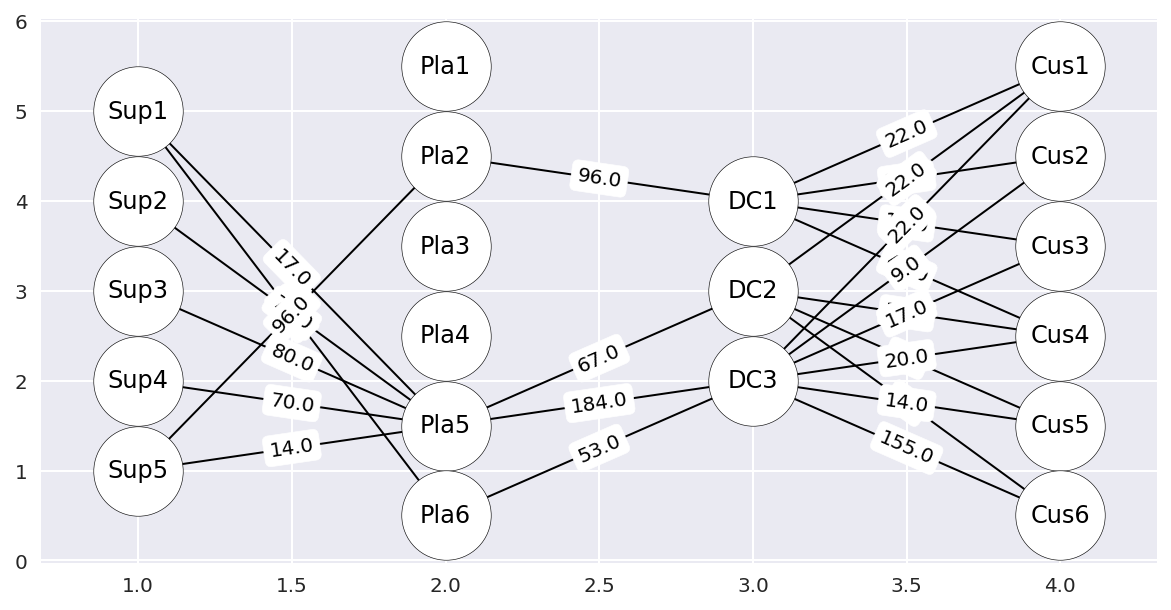

In [67]:
plot_graph(X[0][1], X[1][1], X[2][1])

In [50]:
best_cost = pop[min(range(len(pop)), 
                   key=lambda i: pop[i].fitness.values[0])]
best_cost.fitness.values

(91068.0, 12.115547633219954)

In [68]:
X = transportation_tree(best_cost[:permutation_size], n_nodes, supplies,
                        demands, costs, capacities, 
                        best_cost[permutation_size:])

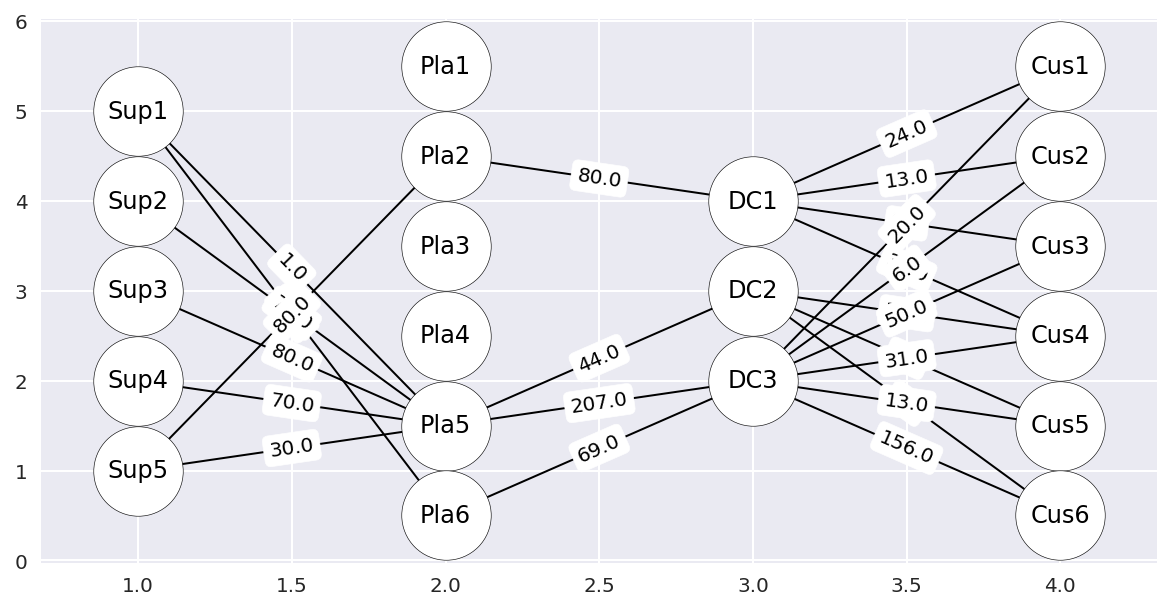

In [69]:
plot_graph(X[0][1], X[1][1], X[2][1])

## Test Library

In [70]:
from multiproduct import init_multiobjective_GA, run_multiobjective_GA

In [71]:
toolbox, stats = init_multiobjective_GA(chromosome, n_nodes, supplies,
                                       demands, costs, capacities)

In [78]:
pop, hof, log = run_multiobjective_GA(chromosome, n_nodes, supplies,
                                     demands, costs, capacities,
                                     pop_size=70, n_generations=100)

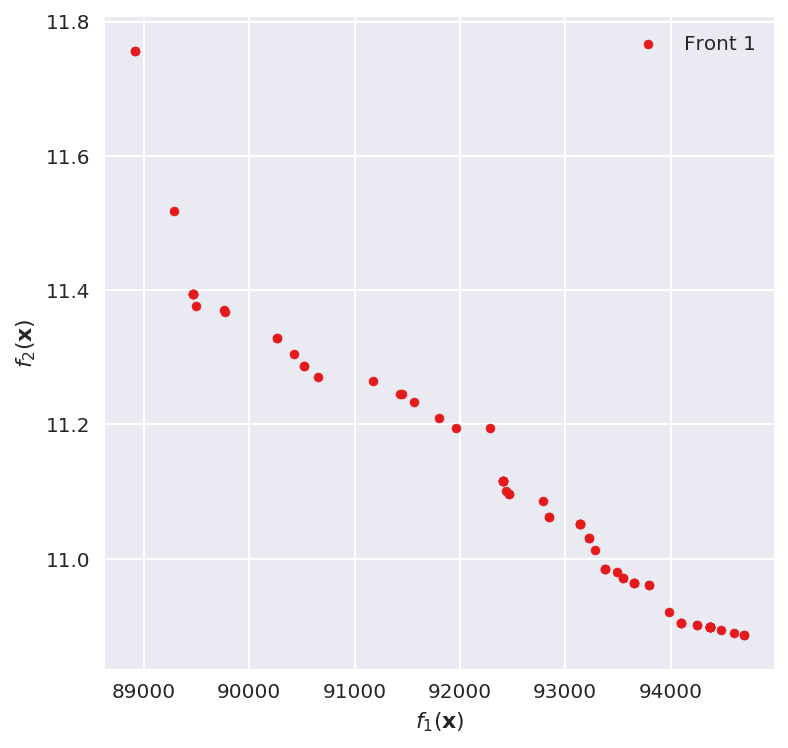

In [79]:
fronts = tools.emo.sortLogNondominated(pop, len(pop))
plot_fronts(fronts, toolbox)